In [15]:
import os

import h5py
from annoy import AnnoyIndex
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [16]:
def get_img_dir(name):
    dir = os.getcwd()
    return dir + '/{}'.format(name)


def get_data(filename):
    f = h5py.File(get_img_dir(filename), 'r')
    return f


def convert_to_1d(image):
    return np.array(image.ravel())


def reshape_with_denorm(image, shape):
    image = image * 255
    return image.reshape(shape).astype(int)


def show_image(arr):
    img2 = Image.fromarray(arr, 'RGB')
    img2.show()


def show_image_plt(arr):
    plt.imshow(arr)
    plt.show()


def plot_gallery(title, images, n_col=5, n_row=3, image_shape=(64, 64)):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)

    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(reshape_with_denorm(comp, image_shape))
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    plt.show()


def save_annoy(filename, X, f, n_trees=10, metric='angular', force=False):
    if not os.path.isfile(get_img_dir(filename)) or force:
        t = AnnoyIndex(f, metric=metric)

        for i, v in enumerate(X):
            t.add_item(i, v)

        t.build(n_trees)
        t.save(filename)


def load_annoy(filename):
    u = AnnoyIndex(f)
    u.load(filename)

    return u


def compute_annoy(X, f, n_trees=10, metric='angular'):
    t = AnnoyIndex(f, metric=metric)

    for i, v in enumerate(X):
        t.add_item(i, v)

    t.build(n_trees)
    t.save('food.ann')

    u = AnnoyIndex(f)
    u.load('food.ann')

    return u


def get_n_closest(index, v, n, search_k=-1):
    return index.get_nns_by_vector(v, n, search_k=search_k)

In [21]:
f = get_data('food_test_c101_n1000_r128x128x3.h5')

print(list(f.keys()))

['category', 'category_names', 'images']


In [22]:
categories = np.array(f['category'])
cat_names = np.array(f['category_names'])
images = np.array(f['images'])
cat_flat = np.array([cat_names[categories[i]][0] for i in range(len(images))])
print(cat_flat)

[b'strawberry_shortcake' b'nachos' b'foie_gras' b'cannoli' b'peking_duck'
 b'beignets' b'crab_cakes' b'beet_salad' b'fish_and_chips'
 b'strawberry_shortcake' b'beet_salad' b'sushi' b'donuts' b'cheese_plate'
 b'pad_thai' b'mussels' b'panna_cotta' b'chicken_curry' b'eggs_benedict'
 b'beet_salad' b'deviled_eggs' b'donuts' b'huevos_rancheros'
 b'fried_calamari' b'pho' b'pizza' b'chicken_quesadilla' b'fish_and_chips'
 b'cheese_plate' b'bread_pudding' b'macaroni_and_cheese'
 b'strawberry_shortcake' b'onion_rings' b'caprese_salad' b'filet_mignon'
 b'chocolate_cake' b'panna_cotta' b'spaghetti_bolognese' b'club_sandwich'
 b'beignets' b'beef_tartare' b'cheesecake' b'deviled_eggs' b'peking_duck'
 b'fried_rice' b'baby_back_ribs' b'hot_dog' b'seaweed_salad'
 b'grilled_salmon' b'frozen_yogurt' b'hamburger' b'cup_cakes'
 b'creme_brulee' b'club_sandwich' b'chocolate_cake' b'croque_madame'
 b'samosa' b'club_sandwich' b'tuna_tartare' b'deviled_eggs'
 b'chicken_curry' b'oysters' b'bread_pudding' b'oyster

In [23]:
shape = images[0].shape
images_flatten = np.array([convert_to_1d(v) for v in images])
images_norm = images_flatten / 255
f = len(images_norm[0])

In [24]:
X, X_test, y, y_test = train_test_split(images_norm, cat_flat, test_size=0.2, random_state=10)

In [32]:
index_filename = 'food.ann'
save_annoy(index_filename, X, f)
u = load_annoy(index_filename)

In [44]:
ex_i = np.random.randint(len(X_test))
ex_item = X_test[ex_i]
ex_item_label = y_test[ex_i]

Label of ex. image:  b'gnocchi'


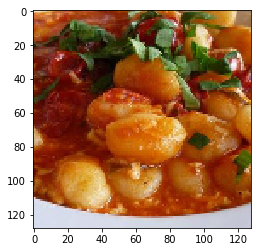

In [45]:
print('Label of ex. image: ', ex_item_label)
show_image_plt(reshape_with_denorm(ex_item, shape))

In [46]:
closest = get_n_closest(u, ex_item, 15)

closest_items = [X[i] for i in closest]
closest_items_lab = [y[i] for i in closest]

Labels of closest images: 
0 :  b'escargots'
1 :  b'lobster_bisque'
2 :  b'lasagna'
3 :  b'creme_brulee'
4 :  b'chicken_curry'
5 :  b'oysters'
6 :  b'risotto'
7 :  b'creme_brulee'
8 :  b'crab_cakes'
9 :  b'onion_rings'
10 :  b'cheese_plate'
11 :  b'gnocchi'
12 :  b'pad_thai'
13 :  b'clam_chowder'
14 :  b'spaghetti_carbonara'


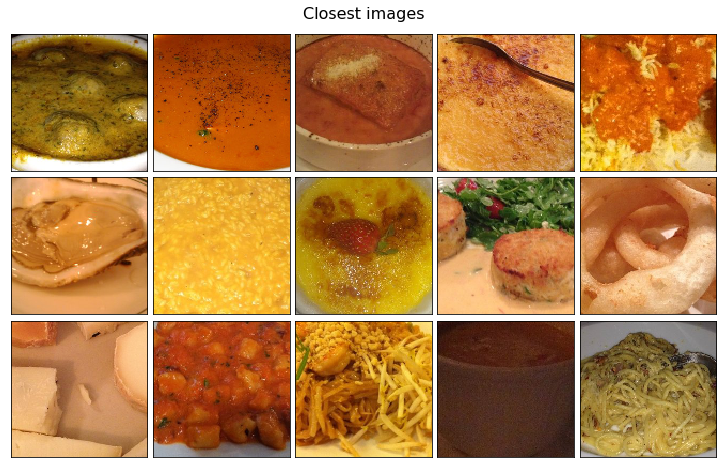

In [47]:
print('Labels of closest images: ')
for i, item in enumerate(closest_items_lab):
    print(i, ': ', item)
plot_gallery('Closest images', closest_items, n_col=5, n_row=3, image_shape=shape)